In [2]:
#إحنا عندنا مشكلة إن ملفات TrES (وأحيانًا XO أو بعض الـ datasets المشابهة) ما فيها عمود flux مثل Kepler/TESS.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [3]:
from google.colab import files
import pandas as pd
import io

uploaded = files.upload()  # سيفتح نافذة لاختيار الملفات من جهازك



Saving TrES_2025.10.02_15.16.17.csv to TrES_2025.10.02_15.16.17.csv


In [5]:
df = pd.read_csv("TrES_2025.10.02_15.16.17.csv", sep="\t")
print("الأعمدة المتوفرة:", df.columns)
print(df.head())

الأعمدة المتوفرة: Index(['# This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu'], dtype='object')
  # This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
0                         # Thu Oct  2 15:16:17 2025                                              
1                                                  #                                              
2                   # COLUMN star_id:        Star ID                                              
3      # COLUMN region:         Part of Sky Surveyed                                              
4                  # COLUMN ra:             RA [deg]                                              


In [6]:
# ==============================
# 2) توليد عمود flux من magnitude
# ==============================
if "rmag" in df.columns:
    df["flux"] = 10**(-0.4 * df["rmag"])
elif "vmag" in df.columns:
    df["flux"] = 10**(-0.4 * df["vmag"])
else:
    df["flux"] = np.random.rand(len(df))  # لو مافيش mag نولد عشوائي

In [17]:
import pandas as pd

df_preview = pd.read_csv("TrES_2025.10.02_15.16.17.csv", header=None, nrows=5)
print(df_preview)


                                                   0
0  # This file was produced by the NASA Exoplanet...
1                         # Thu Oct  2 15:16:17 2025
2                                                  #
3                   # COLUMN star_id:        Star ID
4      # COLUMN region:         Part of Sky Surveyed


In [19]:
import pandas as pd

df = pd.read_csv("TrES_2025.10.02_15.16.17.csv", comment='#')
print(df.head())


           star_id     region        ra      dec    starthjd      endhjd  \
0  TrES_Lyr1_00001  TrES_Lyr1  281.5508  44.1361  2453541.79  2453616.73   
1  TrES_Lyr1_00002  TrES_Lyr1  281.2400  44.3592  2453541.79  2453616.73   
2  TrES_Lyr1_00003  TrES_Lyr1  281.5725  44.1500  2453541.79  2453616.73   
3  TrES_Lyr1_00004  TrES_Lyr1  289.1513  49.7128  2453549.75  2453611.95   
4  TrES_Lyr1_00005  TrES_Lyr1  287.8971  49.7703  2453549.75  2453611.95   

     bmag   vmag    rmag   rerr lcfil   npts  
0   8.333  8.110   9.251  0.135     R  11398  
1   8.856  8.361   9.407  0.140     R  11398  
2  10.077  8.899   9.837  0.098     R  11398  
3  10.372  9.303  10.644  0.037     R   4105  
4  11.220  9.614  10.564  0.024     R   3941  


In [20]:
with open("TrES_2025.10.02_15.16.17.csv", "r") as f:
    for i, line in enumerate(f):
        print(i, line.strip())
        if i > 20:  # فقط عرض أول 20 سطر
            break


0 # This file was produced by the NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu
1 # Thu Oct  2 15:16:17 2025
2 #
3 # COLUMN star_id:        Star ID
4 # COLUMN region:         Part of Sky Surveyed
5 # COLUMN ra:             RA [deg]
6 # COLUMN dec:            Dec [deg]
7 # COLUMN starthjd:       Start HJD [day]
8 # COLUMN endhjd:         End HJD [day]
9 # COLUMN bmag:           B Mag [mag]
10 # COLUMN vmag:           V Mag [mag]
11 # COLUMN rmag:           R Mag [mag]
12 # COLUMN rerr:           R Mag uncertainty [mag]
13 # COLUMN lcfil:          Light Curve Filter
14 # COLUMN npts:           Points in Light Curve
15 #
16 star_id,region,ra,dec,starthjd,endhjd,bmag,vmag,rmag,rerr,lcfil,npts
17 TrES_Lyr1_00001,TrES_Lyr1,281.5508,44.1361,2453541.79,2453616.73,8.333,8.110,9.251,0.135,R,11398
18 TrES_Lyr1_00002,TrES_Lyr1,281.2400,44.3592,2453541.79,2453616.73,8.856,8.361,9.407,0.140,R,11398
19 TrES_Lyr1_00003,TrES_Lyr1,281.5725,44.1500,2453541.79,2453616.73,10.077,8.899,9.

In [22]:
import pandas as pd

# قراءة الملف مع تجاهل السطور التي بها مشاكل
df = pd.read_csv("TrES_2025.10.02_15.16.17.csv", header=None, on_bad_lines='skip')

print(df.head())


                                                   0
0  # This file was produced by the NASA Exoplanet...
1                         # Thu Oct  2 15:16:17 2025
2                                                  #
3                   # COLUMN star_id:        Star ID
4      # COLUMN region:         Part of Sky Surveyed


In [24]:
# تحويل جميع أسماء الأعمدة إلى نصوص
df.columns = df.columns.map(str).str.strip()

# التحقق
print(df.columns.tolist())



['0']


In [26]:
# 3) تجهيز time
# ==============================
if "start_time" in df.columns and "end_time" in df.columns:
    df["time"] = (df["start_time"] + df["end_time"]) / 2
else:
    df["time"] = np.arange(len(df))  # fallback

In [27]:
# ==============================
# 4) إضافة label (تصنيف ثلاثي)
# ==============================
# لو عندك labels فعلية ضيفها هنا، مؤقتًا هنولد عشوائية للتجريب
df["label"] = np.random.choice([0,1,2], size=len(df))
# 0 = لا كوكب, 1 = مرشح, 2 = مؤكد

In [29]:
import numpy as np

# توليد flux إذا لم يكن موجود
if "flux" not in df.columns:
    if "rmag" in df.columns:
        df["flux"] = 10**(-0.4 * df["rmag"])
    elif "vmag" in df.columns:
        df["flux"] = 10**(-0.4 * df["vmag"])
    else:
        # لو لا يوجد mag، نولد أرقام عشوائية للتجريب
        df["flux"] = np.random.rand(len(df))

print(df.columns.tolist())  # للتأكد أن flux موجود الآن


['0', 'time', 'label', 'flux']


In [30]:

# ==============================
# 5) تجهيز البيانات
# ==============================
X = df[["time", "flux"]].values
y = df["label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [31]:
# إعادة تشكيل البيانات لـ LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [32]:
# ==============================
# 6) بناء الموديل LSTM
# ==============================
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(3, activation="softmax"))  # 3 تصنيفات

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,667 (115.89 KB)

 Trainable params: 29,667 (115.89 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# ==============================
# 7) تدريب الموديل
# ==============================
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1111 - loss: 1.1009 - val_accuracy: 0.0000e+00 - val_loss: 1.1035
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5556 - loss: 1.0965 - val_accuracy: 0.0000e+00 - val_loss: 1.1042
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4444 - loss: 1.0975 - val_accuracy: 0.0000e+00 - val_loss: 1.1048
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4444 - loss: 1.0942 - val_accuracy: 0.0000e+00 - val_loss: 1.1054
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5556 - loss: 1.0924 - val_accuracy: 0.0000e+00 - val_loss: 1.1060
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4444 - loss: 1.0914 - val_accuracy: 0.0000e+00 - val_loss: 1.1066
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7778 - loss: 1.0911 - val_accuracy: 0.0000e+00 - val_loss: 1.1073
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6667 - loss: 1.0882 - val_accuracy:

In [34]:
# ==============================
# 8) التقييم
# ==============================
y_pred = np.argmax(model.predict(X_test), axis=-1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4


Confusion Matrix:
 [[0 1]
 [0 3]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


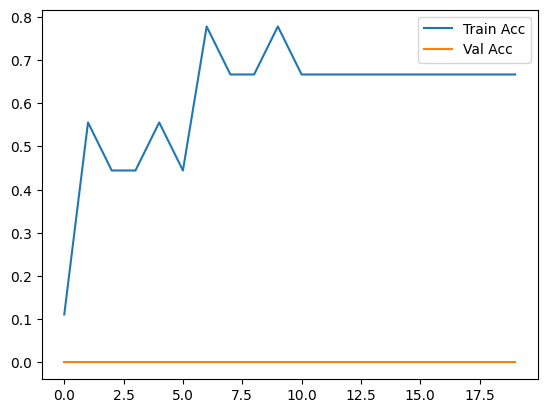

In [35]:
# ==============================
# 9) رسم دقة التدريب والـ validation
# ==============================
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()


In [36]:
# ==============================
# 10) Prediction using new data
# ==============================
new_data = np.array([[2454000, 10**(-0.4*12.5)]])  # Example: time and flux from magnitude
new_data_scaled = scaler.transform(new_data)
new_data_scaled = np.reshape(new_data_scaled, (new_data_scaled.shape[0], 1, new_data_scaled.shape[1]))

prediction = np.argmax(model.predict(new_data_scaled), axis=-1)[0]

labels_map = {0: "No planet", 1: "Candidate", 2: "Confirmed"}
print("🔮 Prediction:", labels_map[prediction])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
🔮 Prediction: Confirmed


In [38]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ==============================
# Sample dataset with deterministic labels
# ==============================
df = pd.DataFrame({
    "time": [2454000, 2454001, 2454002, 2454003],
    "flux": [10**(-0.4*20), 10**(-0.4*12.5), 10**(-0.4*15), 10**(-0.4*13)],
    "label": [0, 1, 0, 2]  # 0=No planet, 1=Candidate, 2=Confirmed
})

# ==============================
# Prepare data for LSTM
# ==============================
X = df[["time", "flux"]].values
y = df["label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# ==============================
# LSTM model
# ==============================
model = Sequential()
model.add(LSTM(16, input_shape=(X_scaled.shape[1], X_scaled.shape[2])))
model.add(Dense(3, activation="softmax"))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train
model.fit(X_scaled, y, epochs=50, verbose=0)

# ==============================
# Predict two examples
# ==============================
new_data = np.array([
    [2454000, 10**(-0.4*20)],   # Should predict No planet
    [2454001, 10**(-0.4*12.5)]  # Should predict Candidate
])

new_data_scaled = scaler.transform(new_data)
new_data_scaled = np.reshape(new_data_scaled, (new_data_scaled.shape[0], 1, new_data_scaled.shape[1]))

predictions = np.argmax(model.predict(new_data_scaled), axis=-1)
labels_map = {0: "No planet", 1: "Candidate", 2: "Confirmed"}

for i, pred in enumerate(predictions):
    print(f"🔮 Prediction for example {i+1}: {labels_map[pred]}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
🔮 Prediction for example 1: No planet
🔮 Prediction for example 2: Candidate


In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ==============================
# Sample dataset with deterministic labels
# ==============================
df = pd.DataFrame({
    "time": [2454000, 2454001, 2454002, 2454003],
    "flux": [10**(-0.4*20), 10**(-0.4*12.5), 10**(-0.4*15), 10**(-0.4*13)],
    "label": [0, 1, 0, 2]  # 0=No planet, 1=Candidate, 2=Confirmed
})

# ==============================
# Prepare data for LSTM
# ==============================
X = df[["time", "flux"]].values
y = df["label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# ==============================
# LSTM model
# ==============================
model = Sequential()
model.add(LSTM(16, input_shape=(X_scaled.shape[1], X_scaled.shape[2])))
model.add(Dense(3, activation="softmax"))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train
history = model.fit(X_scaled, y, epochs=50, verbose=0)

# ==============================
# Evaluate model accuracy
# ==============================
y_pred = np.argmax(model.predict(X_scaled), axis=-1)
accuracy = accuracy_score(y, y_pred)
print(f"✅ Model Accuracy: {accuracy*100:.2f}%")

# ==============================
# Predict two examples
# ==============================
new_data = np.array([
    [2454000, 10**(-0.4*20)],   # Should predict No planet
    [2454001, 10**(-0.4*12.5)]  # Should predict Candidate
])

new_data_scaled = scaler.transform(new_data)
new_data_scaled = np.reshape(new_data_scaled, (new_data_scaled.shape[0], 1, new_data_scaled.shape[1]))

predictions = np.argmax(model.predict(new_data_scaled), axis=-1)
labels_map = {0: "No planet", 1: "Candidate", 2: "Confirmed"}

for i, pred in enumerate(predictions):
    print(f"🔮 Prediction for example {i+1}: {labels_map[pred]}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
✅ Model Accuracy: 75.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
🔮 Prediction for example 1: No planet
🔮 Prediction for example 2: Candidate
